In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates

from xfrites.conn.conn_spec  import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Loading data

In [3]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '141017', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

In [4]:
#### Surrogate data
n_surr    = 10
data_surr = []
for i in range(n_surr): data_surr += [trial_swap_surrogates(data, seed = i*500, verbose=False)]

#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [5]:
channel_labels = np.array([12, 17, 18, 181, 69,104,95,106])

In [6]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where( data.attrs["channels_labels"]==c )[0][0]]

In [7]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [8]:
pairs = np.array([[6,11],
                  [11,12],
                  [11,65],
                  [30,39],
                  [36,41]])

### Spectral analysis

#### Define parameters

In [20]:
# Smoothing windows

sm_times  = 1.0
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles     = freqs/2

In [21]:
kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=pairs,
    mode=mode, n_cycles=n_cycles, decim=decim, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=1,mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=67, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   20.1s remaining:    0.5s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   20.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [13]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr): coh_surr += [conn_spec(data_surr[i], **kw)]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   19.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   26.0s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   26.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   20.6s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   27.3s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   27.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.0s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.5s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.4s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.7s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.6s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.4s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.4s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   20.7s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   27.7s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.3s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.7s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.8s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.0s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.3s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.4s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.8s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.8s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   30.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.3s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.1s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.7s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.8s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.1s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.4s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.4s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   22.4s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   29.5s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   30.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   23.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   30.3s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   30.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.6s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.5s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   28.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   21.8s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   28.9s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   29.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [14]:
coh_surr = xr.concat(coh_surr, dim="seeds")

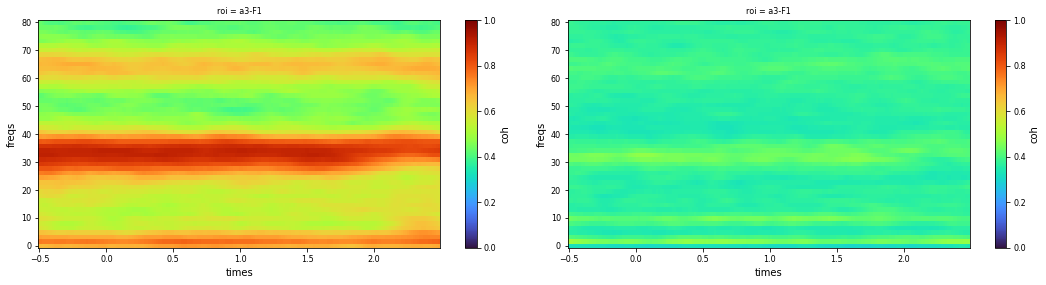

In [15]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
coh.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);
plt.subplot(1,2,2)
coh_surr.mean(dim=("trials","seeds")).sel(times=slice(-0.5,2.5)).isel(roi=4).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);
plt.tight_layout()

No handles with labels found to put in legend.


(0.0, 80.0)

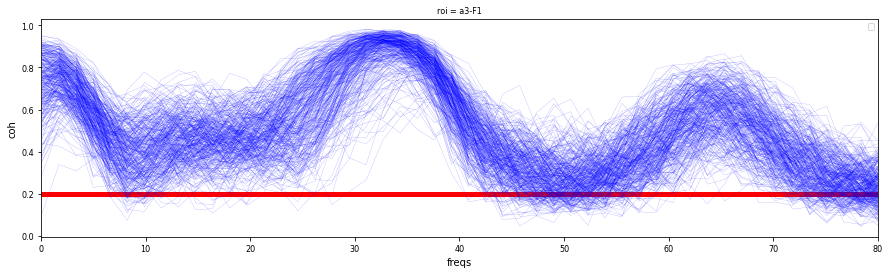

In [22]:
plt.figure(figsize=(15,4))
coh.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=.1, color="b");
plt.hlines(0.2, 0, 80, "r", lw=5)
plt.legend();
#coh_surr.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").quantile(0.95, "seeds").plot(x="freqs", hue="trials", lw=.1, color="r");
#plt.legend();
plt.xlim(0, 80)

In [17]:
thr = coh_surr.quantile(0.95, "seeds")

In [18]:
aux = (coh>=thr)*coh

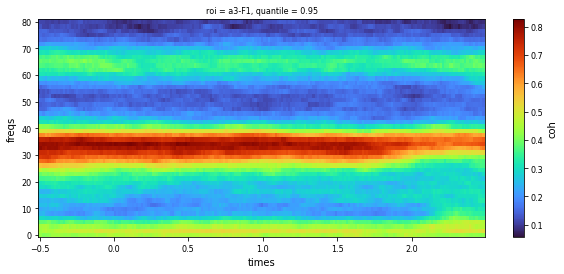

In [19]:
plt.figure(figsize=(10,4))
aux.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo");

No handles with labels found to put in legend.


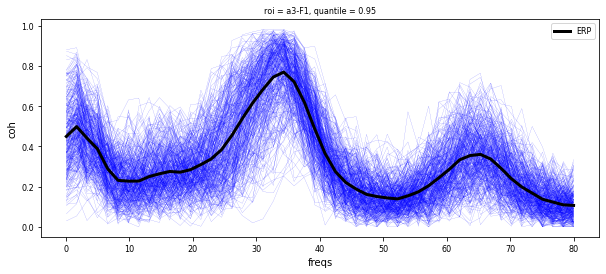

In [20]:
plt.figure(figsize=(10,4))
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=.1, color="b");
plt.legend()
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").mean("trials").plot(x="freqs", hue="trials", lw=3, color="k", label="ERP");
plt.legend()

In [21]:
aux

<xarray.DataArray 'coh' (trials: 332, roi: 5, freqs: 5, times: 244)>
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.80549235,
          0.83190394, 0.85145678],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.82986835, 0.85078565],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.90730694,
          0.91880381, 0.92798315],
         [0.        , 0.        , 0.        , ..., 0.73763209,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.82754703,
          0.82128612, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.82427376,
          0.84260252, 0.85801308],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.92368609,
          0.94148973, 0.95431183],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.85031613, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.89634364, 0.86878721, 0.84692026, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.87885249, 0.85493749, 0.83090205, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.75981928,
          0.        , 0.        ],
         [0.95544945, 0.94914241, 0.94034835, ..., 0.86444517,
          0.89096399, 0.9121542 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]],


       [[[0.91149083, 0.88245562, 0.85024614, ..., 0.        ,
          0.        , 0.        ],
         [0.92405787, 0.8794081 , 0.82480942, ..., 0.78767571,
          0.80176137, 0.81742618],
         [0.83354573, 0.79885066, 0.76170504, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.76539742, 0.74628006, 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.90730086, 0.86826123, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.88185982, 0.8565426 , ..., 0.        ,
          0.        , 0.        ],
         [0.83876704, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.77327447, 0.75834726, ..., 0.        ,
          0.        , 0.      

In [4]:
xr.load_dataset("~/storage1/projects/GrayData-Analysis/Results/lucy/141017/session01/coh_k_0.5_surr_True_morlet.nc")

<xarray.Dataset>
Dimensions:  (freqs: 5, roi: 3321, times: 244, trials: 595)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 766 768 769 771 772 773 774 775
  * roi      (roi) object 'a46D-a8B' 'a46D-F6' 'a46D-a9/46D' ... 'V1-V1' 'V1-V1'
  * freqs    (freqs) float64 3.361 10.7 20.48 34.34 61.25
  * times    (times) float64 -0.65 -0.635 -0.62 -0.605 ... 2.95 2.965 2.98 2.995
Data variables:
    coh      (roi, freqs, trials, times) float32 0.55842113 ... 0.5595775